In this project, we are looking at Coronary artery disease, which is a common heart disease where the major blood vessels are clogged or narrowed. Due to the blockage, it is difficult to transfer oxygen, blood and nutrients to the heart. Usually, this disease can be attributed to cholesterol deposits, so the level of cholesterol in potential victims is of interest to us. In this project, we would like to determine whether a fictional person would be at risk of heart disease based on their attributes.

The dataset we chose was the one about heart disease. The database for heart disease contains 76 attributes (variables), but the dataset we are using includes only 14 of them. In our project, we will focus on determining the presence or absence of heart disease, so the data in the disease column has only two categories, 0 (no heart disease) and 1 (with heart disease). Also, this database has four regional datasets, and we finally chose the Hungarian regional. 

In [10]:
library(tidyverse)
library(repr)
options(repr.matrix.max.rows = 6)
library(tidymodels)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org



In [7]:
#First step is to read the data and label the column names. 
heart_data <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data",col_name = FALSE)
colnames(heart_data) <- c("age", "sex", "chest_pain", "resting_bp", "cholesterol", "fbs>120mg/dL", "restingecg", "max_heart_rate", "exercise_induced_angina", "oldpeak", "slope", "ca", "thal", "disease")

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [11]:
#Here we are tidying the data by filtering out columns with "?" and selecting which columns we want. 
heart_data_tidy <- heart_data |> select(chest_pain, resting_bp, cholesterol, restingecg, max_heart_rate, disease) |>
                   filter(chest_pain!= "?", resting_bp!= "?", cholesterol!= "?", restingecg!= "?", max_heart_rate!= "?", disease!= "?") |>
                   mutate(chest_pain = as.numeric(chest_pain), 
                          resting_bp = as.numeric(resting_bp),
                          cholesterol = as.numeric(cholesterol),
                          restingecg = as.numeric(restingecg),
                          max_heart_rate = as.numeric(max_heart_rate),
                          disease = as_factor(disease))

In [12]:
heart_split <- initial_split(heart_data_tidy, prop = .75, strata = disease)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)
heart_train

chest_pain,resting_bp,cholesterol,restingecg,max_heart_rate,disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2,130,132,2,185,0
1,170,237,1,170,0
2,105,198,0,165,0
⋮,⋮,⋮,⋮,⋮,⋮
4,160,331,0,94,1
2,180,393,0,110,1
4,130,275,1,115,1


In [16]:
#Preliminary exploratory data analysis; missing values were ommited so there are zero rows with missing values
#Finding mean of all numerical predictors
heart_data_miss_num <- heart_train |>
                       map_df(is.na) |>
                       map_df(sum)
heart_data_miss_num

heart_data_obs_num <- heart_train |>
                      summarize(n_cp=n(),n_rbp=n(),n_cholesterol=n(),n_max_heart_rate=n(),n_disease=n())
heart_data_obs_num

heart_data_mean <- heart_train |>
    select(resting_bp, cholesterol, max_heart_rate) |>
    map_dfr(mean)
heart_data_mean

#Finding number of observations for each class
heart_num_class <- heart_train |>
    group_by(disease) |>
    summarize(n=n())
heart_num_class

chest_pain,resting_bp,cholesterol,restingecg,max_heart_rate,disease
<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0


n_cp,n_rbp,n_cholesterol,n_max_heart_rate,n_disease
<int>,<int>,<int>,<int>,<int>
201,201,201,201,201


resting_bp,cholesterol,max_heart_rate
<dbl>,<dbl>,<dbl>
133.0398,250.1144,140.0199


disease,n
<fct>,<int>
0,126
1,75


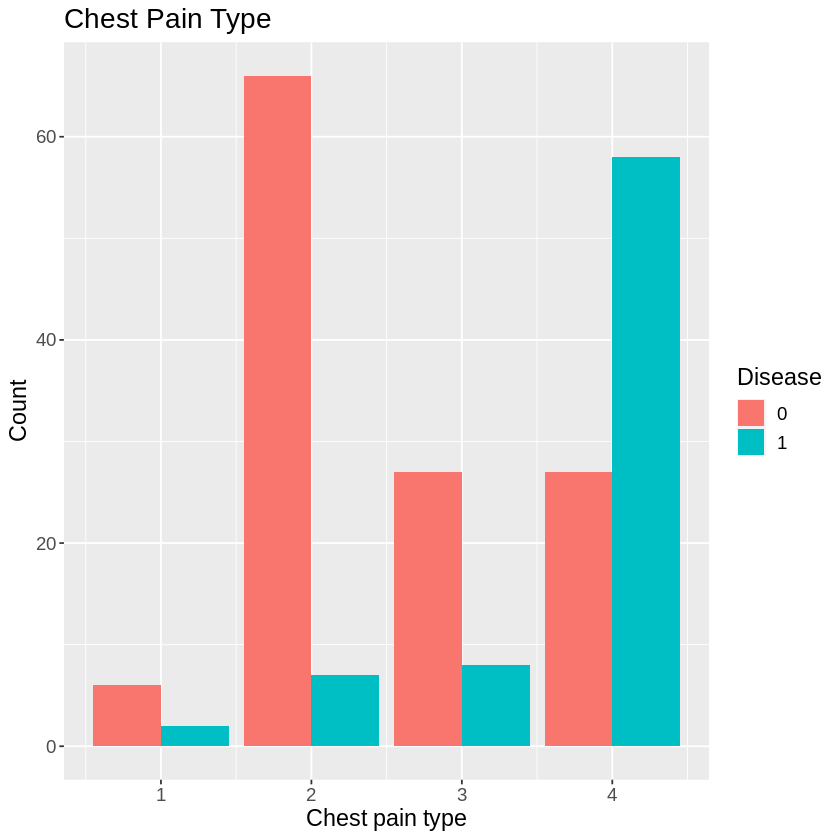

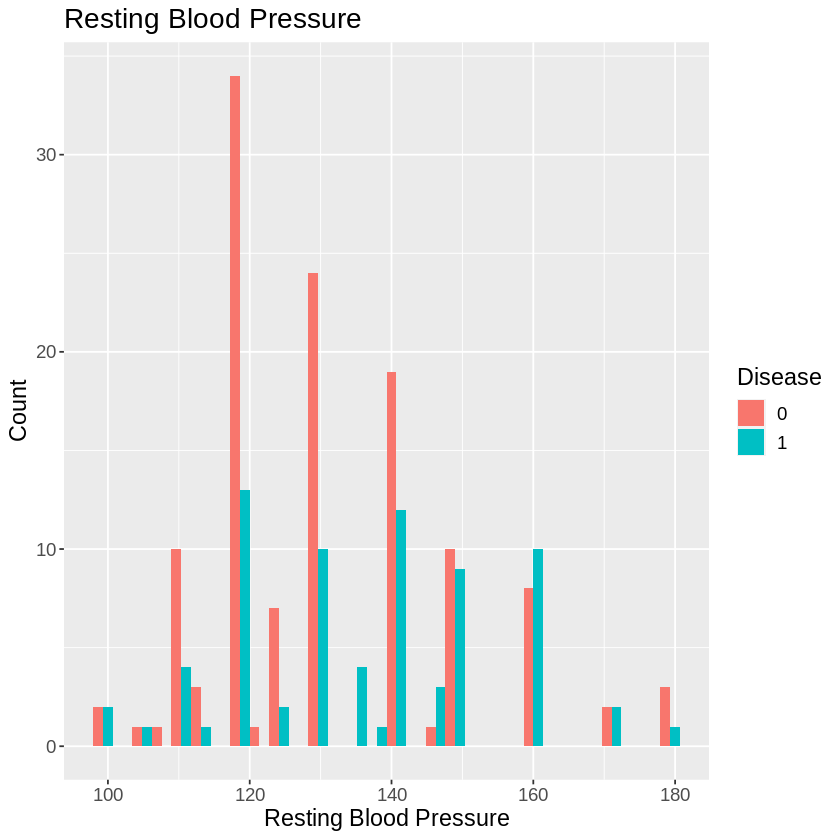

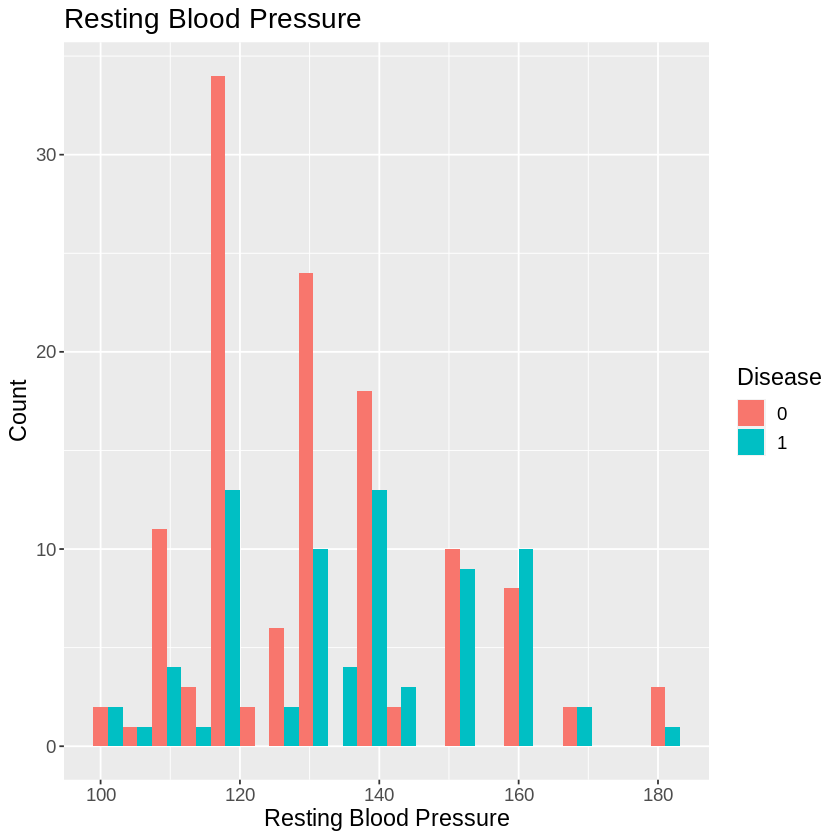

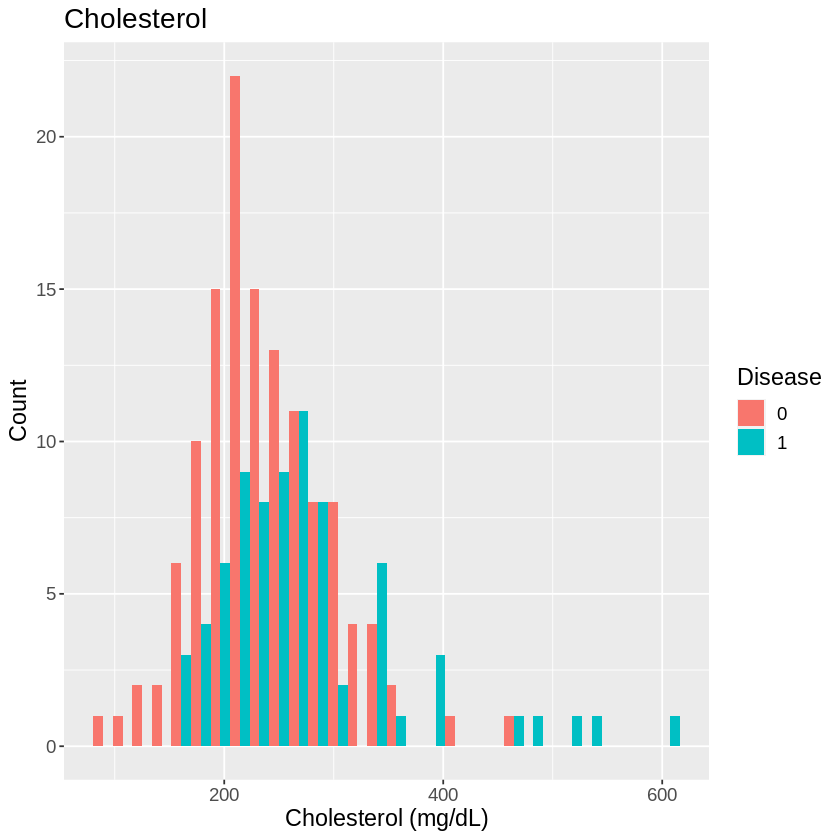

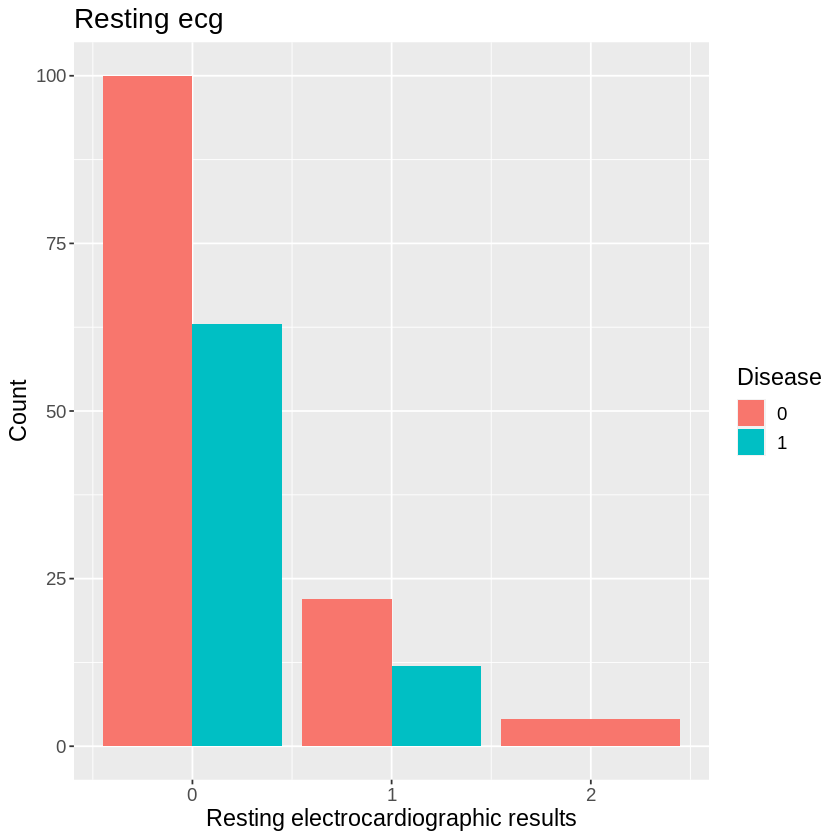

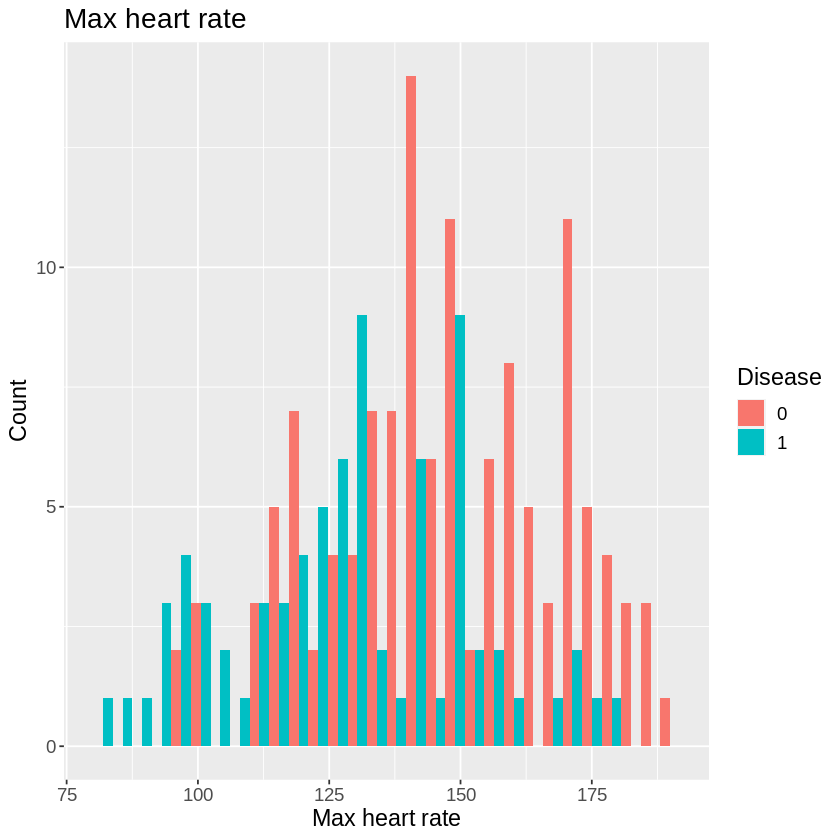

In [18]:
#Preliminary exploratory data analysis; visualization of predictor distribution
chest_pain_plot <- ggplot(heart_train , 
                   aes(x = chest_pain, fill = disease)) +
                   geom_bar(position= "dodge") +
                   labs(x = "Chest pain type", y = "Count",  fill = "Disease") +
                   ggtitle("Chest Pain Type") +
                   theme(text = element_text(size = 14))
chest_pain_plot
restingbp_plot <- ggplot(heart_train , 
                   aes(x = resting_bp, fill = disease)) +
                   geom_histogram(position= "dodge", bins=30) +
                   labs(x = "Resting Blood Pressure", y = "Count",  fill = "Disease") +
                   ggtitle("Resting Blood Pressure") +
                   theme(text = element_text(size = 14))
restingbp_plot
chol_plot <- ggplot(heart_train , 
                   aes(x = resting_bp, fill = disease)) +
                   geom_histogram(position= "dodge", bins=20) +
                   labs(x = "Resting Blood Pressure", y = "Count",  fill = "Disease") +
                   ggtitle("Resting Blood Pressure") +
                   theme(text = element_text(size = 14))
chol_plot
restingecg_plot <- ggplot(heart_train , 
                   aes(x = cholesterol, fill = disease)) +
                   geom_histogram(position= "dodge", bins=30) +
                   labs(x = "Cholesterol (mg/dL)", y = "Count",  fill = "Disease") +
                   ggtitle("Cholesterol") +
                   theme(text = element_text(size = 14))
restingecg_plot
restingecg_plot <- ggplot(heart_train , 
                   aes(x = restingecg, fill = disease)) +
                   geom_bar(position= "dodge") +
                   labs(x = "Resting electrocardiographic results", y = "Count",  fill = "Disease") +
                   ggtitle("Resting ecg") +
                   theme(text = element_text(size = 14))
restingecg_plot
max_heart_rate_plot <- ggplot(heart_train , 
                   aes(x = max_heart_rate, fill = disease)) +
                   geom_histogram(position= "dodge", bins=30) +
                   labs(x = "Max heart rate", y = "Count",  fill = "Disease") +
                   ggtitle("Max heart rate") +
                   theme(text = element_text(size = 14))
max_heart_rate_plot